##### import libs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightfm
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

In [2]:
from utils import evaluate, load_data

In [3]:
pd.set_option('display.max_rows', 100)

##### read data

In [5]:
user_item_data, user_meta_data, item_meta_data, test_pairs_data = load_data()

## fun

In [5]:
user_item_data.explicit.value_counts()

explicit
 0    138821753
 1      6788267
-1        57262
Name: count, dtype: int64

In [6]:
user_item_data[["user_id", "item_id"]].duplicated().sum()

0

In [12]:
user_item_data.groupby(by="user_id").like.agg("max").value_counts()

like
1    146207
0     37197
Name: count, dtype: int64

In [51]:
like_count_by_item = user_item_data.groupby(by="item_id").like.agg("sum")

In [86]:
most_popular_items = like_count_by_item.value_counts().sort_index()[-20:].index.to_list()

In [88]:
for item_id in most_popular_items:
    plt.plot(user_item_data[user_item_data.item_id == item_id].like.values.cumsum())
    plt.plot((0, len(user_item_data[user_item_data.item_id == item_id])),
            (0, user_item_data[user_item_data.item_id == item_id].like.sum()))
    plt.savefig(f"most_popular_items/{item_id=}.png")
    plt.close()

In [38]:
like_count_by_user = user_item_data.groupby(by="user_id").like.agg("sum")
like_ratio_by_user = like_count_by_user / user_item_data.groupby(by="user_id").like.agg(len)

In [48]:
p = like_count_by_user.values / np.sum(like_count_by_user.values)
q = like_ratio_by_user / np.sum(like_ratio_by_user)
kl_divergence = np.sum(p * np.log(p / q))
print(kl_divergence)

0.4291450819922385


In [89]:
most_popular_users = like_count_by_user.value_counts().sort_index()[-20:].index.to_list()

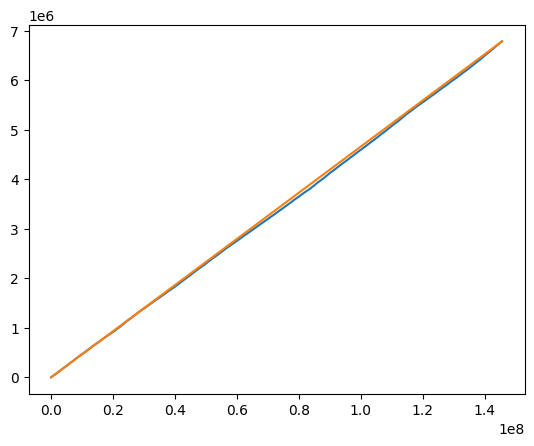

In [91]:
plt.plot(user_item_data.like.values.cumsum())
plt.plot((0, len(user_item_data)),
        (0, user_item_data.like.sum()))

In [90]:
for user_id in most_popular_items:
    plt.plot(user_item_data[user_item_data.user_id == user_id].like.values.cumsum())
    plt.plot((0, len(user_item_data[user_item_data.user_id == user_id])),
            (0, user_item_data[user_item_data.user_id == user_id].like.sum()))
    plt.savefig(f"most_popular_users/{user_id=}.png")
    plt.close()

In [5]:
user_id, item_id = test_pairs_data.loc[0]

In [29]:
duration = item_meta_data[item_meta_data.item_id == item_id].duration.values[0]

In [30]:
user_item_data[user_item_data.item_id == item_id].head()

,user_id,item_id,timespent,like,dislike,share,bookmarks
5022,146103,7363,2,0,0,0,0
71267,132755,7363,8,0,0,0,0
75619,13352,7363,5,0,0,0,0
105801,79700,7363,15,0,0,0,0
137004,166203,7363,2,0,0,0,0


In [7]:
item_meta_data.head()

,item_id,source_id,duration,embeddings
0,0,1869,13,"[0.07607838, 0.24312432, -0.07126159, 0.068710..."
1,1,1869,8,"[-0.2897247, 0.016220074, -0.14935663, 0.08754..."
2,2,1869,10,"[-0.08479501, 0.16359554, -0.12039807, 0.09242..."
3,3,1869,49,"[-0.061852332, 0.14139329, -0.00040801117, -0...."
4,4,1869,8,"[-0.12159933, -0.019279012, -0.13987888, 0.020..."


In [8]:
user_item_data = user_item_data.merge(item_meta_data.drop(columns=["embeddings"]),
                                      on="item_id",
                                      how="left")

In [9]:
user_item_data["timespent_rel"] = user_item_data["timespent"] / user_item_data["duration"]

In [10]:
user_item_data.head()

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit,source_id,duration,timespent_rel
0,3810,138979,6,0,0,0,0,0,4278,54,0.111111
1,101874,331160,6,0,0,0,0,0,2049,6,1.000000
2,150332,73709,11,0,0,0,0,0,16375,16,0.687500
3,4982,189745,5,0,0,0,0,0,166,25,0.200000
4,149601,289643,1,0,0,1,0,0,1459,23,0.043478


<Axes: >

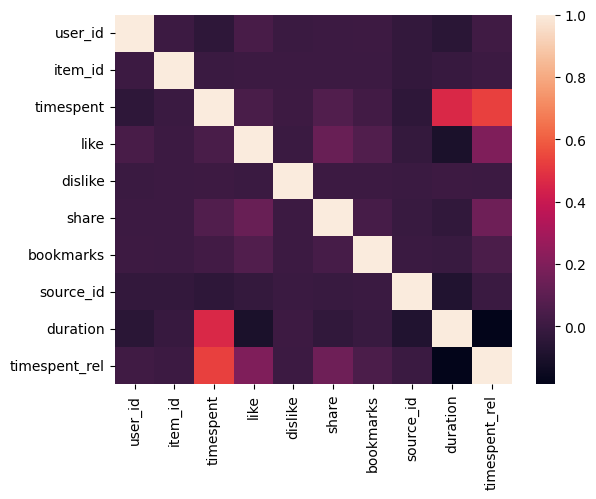

In [12]:
corr = user_item_data.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [13]:
corr

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel
user_id,1.000000,0.001549,-0.041699,0.040694,-0.001321,0.001801,0.007537,-0.024721,-0.053166,0.015552
item_id,0.001549,1.000000,-0.005046,0.000882,0.000007,0.000899,-0.000070,-0.028045,-0.010296,0.001892
timespent,-0.041699,-0.005046,1.000000,0.042656,0.005639,0.066744,0.021085,-0.042133,0.458321,0.529553
like,0.040694,0.000882,0.042656,1.000000,-0.004384,0.132167,0.065168,-0.021740,-0.099569,0.195575
dislike,-0.001321,0.000007,0.005639,-0.004384,1.000000,-0.000306,0.003284,-0.001131,0.004990,0.002365
share,0.001801,0.000899,0.066744,0.132167,-0.000306,1.000000,0.034540,-0.006479,-0.029672,0.149015
bookmarks,0.007537,-0.000070,0.021085,0.065168,0.003284,0.034540,1.000000,-0.004311,-0.007126,0.046041
source_id,-0.024721,-0.028045,-0.042133,-0.021740,-0.001131,-0.006479,-0.004311,1.000000,-0.080420,-0.001658
duration,-0.053166,-0.010296,0.458321,-0.099569,0.004990,-0.029672,-0.007126,-0.080420,1.000000,-0.186316
timespent_rel,0.015552,0.001892,0.529553,0.195575,0.002365,0.149015,0.046041,-0.001658,-0.186316,1.000000


##### split data

In [11]:
ui_train, ui_val = train_test_split(user_item_data,
                                    test_size=0.15,
                                    random_state=42,
                                    shuffle=False)

In [34]:
(liked.timespent_rel<0.1).sum()/len(liked)

0.0072636332627561565

In [12]:
liked = ui_train[ui_train.like==1]
disliked = ui_train[ui_train.dislike==1]

In [39]:
(liked.timespent_rel>1).sum()/len(liked)

0.510207667360562

In [43]:
(liked.bookmarks).sum()/len(liked)

0.01005633075179102

In [14]:
disliked.head()

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit,source_id,duration,timespent_rel
5172,154017,65516,36,0,1,0,0,-1,11641,96,0.375000
5621,44951,260035,107,0,1,0,0,-1,12660,27,3.962963
12945,3178,37675,21,0,1,0,0,-1,15682,17,1.235294
13046,58716,226560,15,0,1,0,0,-1,13673,47,0.319149
16902,15760,15180,41,0,1,0,0,-1,3318,41,1.000000


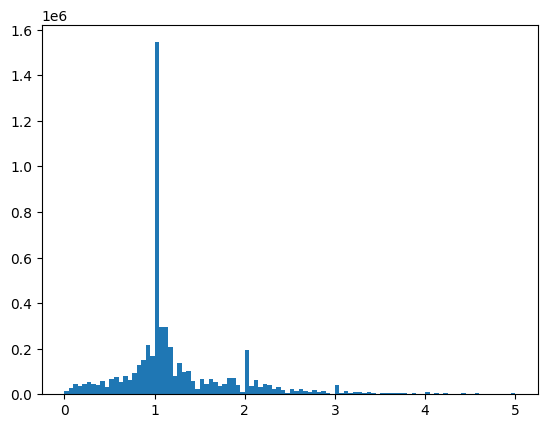

In [15]:
plt.hist(liked.timespent_rel,
         bins=100,
         range=(0,5))
plt.show()

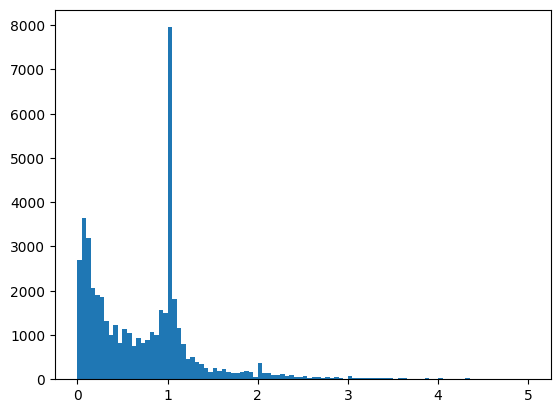

In [59]:
plt.hist(disliked.timespent_rel,
         bins=100,
         range=(0,5))
plt.show()

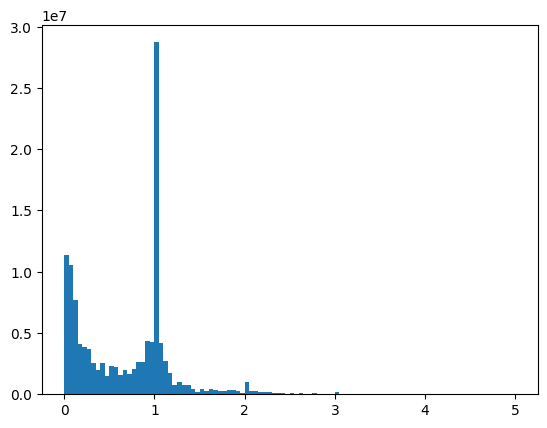

In [16]:
plt.hist(ui_train.timespent_rel,
         bins=100,
         range=(0,5))
plt.show()

вывод: практически нет лайков с околонулевым timespent_rel

In [72]:
(ui_train.like.astype(int) - ui_train.dislike).unique()

array([ 0,  1, -1])

<Axes: >

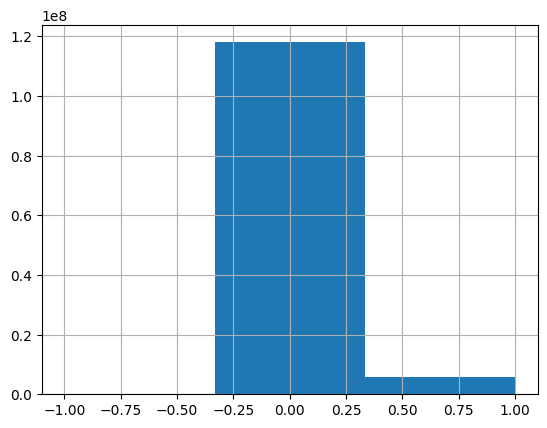

In [73]:
(ui_train.like.astype(int) - ui_train.dislike).hist(bins=3)

<Axes: >

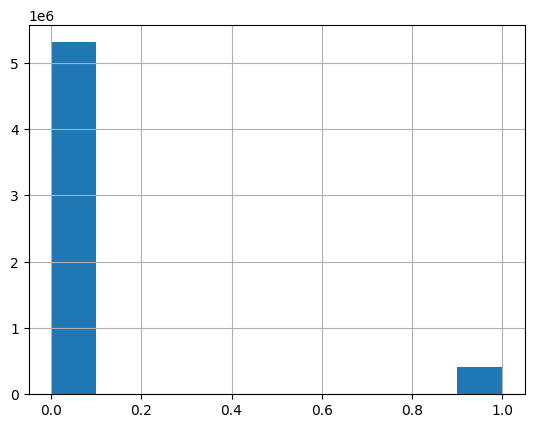

In [65]:
liked.share.hist()

In [74]:
shared = ui_train[ui_train.share == 1]

<Axes: >

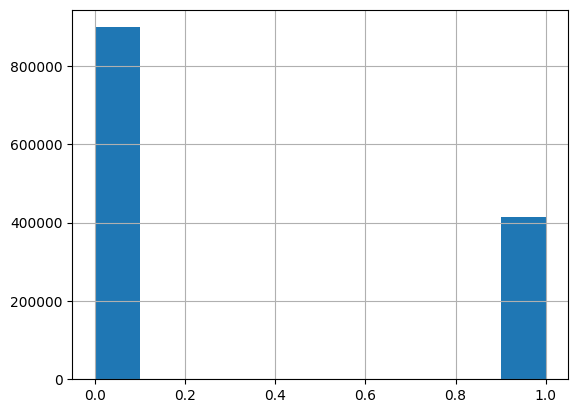

In [76]:
shared.like.hist()

In [15]:
ui_train["skipped"] = ui_train["timespent"] < 2

In [50]:
train_corr = ui_train.corr()

In [51]:
train_corr

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel,skipped
user_id,1.000000,0.001844,-0.041510,0.040867,-0.001346,0.002052,0.007363,-0.025984,-0.053056,0.015938,0.009521
item_id,0.001844,1.000000,-0.005022,0.000779,-0.000024,0.000840,-0.000008,-0.027197,-0.010569,0.002313,-0.000005
timespent,-0.041510,-0.005022,1.000000,0.043284,0.005536,0.067186,0.021156,-0.042672,0.455320,0.532623,-0.293101
like,0.040867,0.000779,0.043284,1.000000,-0.004356,0.133063,0.064381,-0.023153,-0.099247,0.195671,-0.072833
dislike,-0.001346,-0.000024,0.005536,-0.004356,1.000000,-0.000258,0.003142,-0.001080,0.004964,0.002309,-0.004370
share,0.002052,0.000840,0.067186,0.133063,-0.000258,1.000000,0.034109,-0.006732,-0.029074,0.148352,-0.035293
bookmarks,0.007363,-0.000008,0.021156,0.064381,0.003142,0.034109,1.000000,-0.004460,-0.006969,0.045737,-0.010390
source_id,-0.025984,-0.027197,-0.042672,-0.023153,-0.001080,-0.006732,-0.004460,1.000000,-0.081364,-0.002258,-0.006549
duration,-0.053056,-0.010569,0.455320,-0.099247,0.004964,-0.029074,-0.006969,-0.081364,1.000000,-0.186187,-0.011287
timespent_rel,0.015938,0.002313,0.532623,0.195671,0.002309,0.148352,0.045737,-0.002258,-0.186187,1.000000,-0.332434


<Axes: >

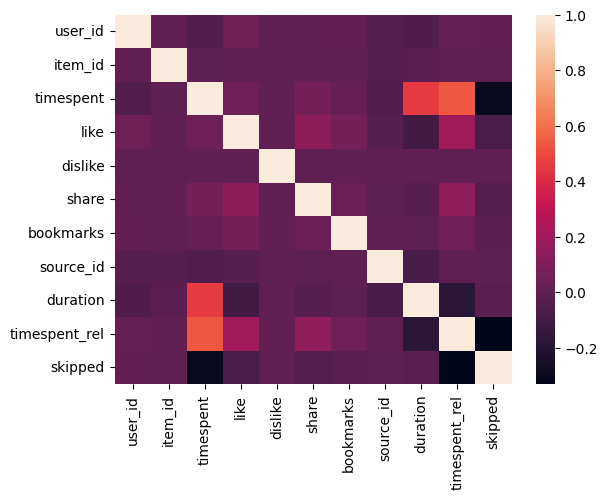

In [52]:
sns.heatmap(train_corr,
            xticklabels=train_corr.columns.values,
            yticklabels=train_corr.columns.values)

In [53]:
ui_train.head()

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel,skipped
0,3810,138979,6,0,0,0,0,4278,54,0.111111,False
1,101874,331160,6,0,0,0,0,2049,6,1.000000,False
2,150332,73709,11,0,0,0,0,16375,16,0.687500,False
3,4982,189745,5,0,0,0,0,166,25,0.200000,False
4,149601,289643,1,0,0,1,0,1459,23,0.043478,True


In [54]:
reaction_stats = ui_train[["item_id", "like", "dislike"]].\
    groupby(by="item_id").\
        agg(
            like_sum=pd.NamedAgg(column="like", aggfunc="sum"),
            like_mean=pd.NamedAgg(column="like", aggfunc="mean"),
            dislike_sum=pd.NamedAgg(column="dislike", aggfunc="sum"),
            dislike_mean=pd.NamedAgg(column="dislike", aggfunc="mean"),    
)

In [55]:
ui_val = ui_val.merge(reaction_stats,
                      on="item_id",
                      how="left"
                      )

In [56]:
ui_val

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel,like_sum,like_mean,dislike_sum,dislike_mean
0,29421,237758,16,0,0,0,0,7189,49,0.326531,0.0,0.000000,0.0,0.000000
1,27720,21760,29,0,0,0,0,2335,29,1.000000,53.0,0.011746,1.0,0.000222
2,83709,211636,1,0,0,0,0,2108,38,0.026316,97.0,0.025846,0.0,0.000000
3,4291,207817,1,0,0,0,0,12415,34,0.029412,7.0,0.030303,0.0,0.000000
4,38103,303606,14,0,0,0,0,11337,12,1.166667,302.0,0.098596,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21850088,10718,93558,7,0,0,0,0,17864,54,0.129630,69.0,0.007362,8.0,0.000854
21850089,119164,60206,60,0,0,0,0,13642,59,1.016949,16.0,0.009901,0.0,0.000000
21850090,171518,99323,70,0,0,0,0,13584,39,1.794872,2.0,0.043478,0.0,0.000000
21850091,109533,74203,1,0,0,0,0,9528,25,0.040000,21.0,0.048165,1.0,0.002294


In [23]:
ui_train

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel,skipped
0,3810,138979,6,0,0,0,0,4278,54,0.111111,False
1,101874,331160,6,0,0,0,0,2049,6,1.000000,False
2,150332,73709,11,0,0,0,0,16375,16,0.687500,False
3,4982,189745,5,0,0,0,0,166,25,0.200000,False
4,149601,289643,1,0,0,1,0,1459,23,0.043478,True
...,...,...,...,...,...,...,...,...,...,...,...
123817184,150538,329813,7,0,0,0,0,18243,10,0.700000,False
123817185,162954,109529,6,1,0,0,0,16629,10,0.600000,False
123817186,179558,317716,7,0,0,0,0,2116,7,1.000000,False
123817187,133207,7666,11,0,0,0,0,5119,10,1.100000,False


In [57]:
val_corr = ui_val.corr()

In [60]:
val_corr["like"]

user_id          0.039810
item_id          0.001415
timespent        0.039160
like             1.000000
dislike         -0.004547
share            0.127442
bookmarks        0.069273
source_id       -0.013772
duration        -0.101154
timespent_rel    0.194853
like_sum         0.122349
like_mean        0.230779
dislike_sum     -0.039052
dislike_mean    -0.017803
Name: like, dtype: float64

<Axes: >

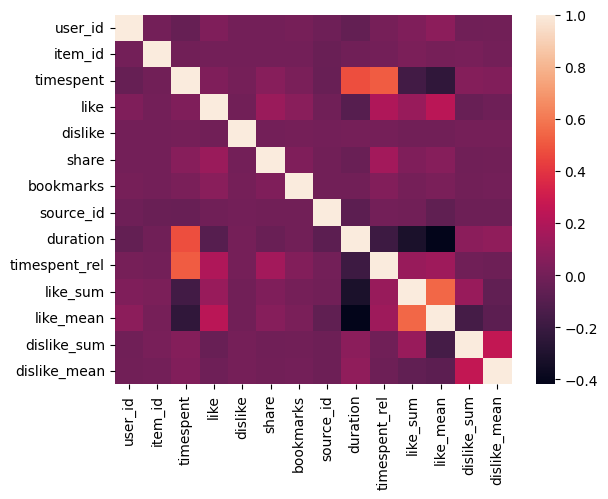

In [58]:
sns.heatmap(val_corr,
            xticklabels=val_corr.columns.values,
            yticklabels=val_corr.columns.values)

In [61]:
ui_val

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel,like_sum,like_mean,dislike_sum,dislike_mean
0,29421,237758,16,0,0,0,0,7189,49,0.326531,0.0,0.000000,0.0,0.000000
1,27720,21760,29,0,0,0,0,2335,29,1.000000,53.0,0.011746,1.0,0.000222
2,83709,211636,1,0,0,0,0,2108,38,0.026316,97.0,0.025846,0.0,0.000000
3,4291,207817,1,0,0,0,0,12415,34,0.029412,7.0,0.030303,0.0,0.000000
4,38103,303606,14,0,0,0,0,11337,12,1.166667,302.0,0.098596,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21850088,10718,93558,7,0,0,0,0,17864,54,0.129630,69.0,0.007362,8.0,0.000854
21850089,119164,60206,60,0,0,0,0,13642,59,1.016949,16.0,0.009901,0.0,0.000000
21850090,171518,99323,70,0,0,0,0,13584,39,1.794872,2.0,0.043478,0.0,0.000000
21850091,109533,74203,1,0,0,0,0,9528,25,0.040000,21.0,0.048165,1.0,0.002294


In [18]:
u_train = ui_train.user_id
i_train = ui_train.item_id
likes_train = ui_train.like
dislikes_train = ui_train.dislike

u_val = ui_val.user_id
i_val = ui_val.item_id
likes_val = ui_val.like
dislikes_val = ui_val.dislike

In [19]:
reaction_train = coo_matrix((likes_train-dislikes_train, (u_train, i_train)))
reaction_val = coo_matrix((likes_val-dislikes_val, (u_val, i_val)))
share_train = coo_matrix((ui_train.share, (u_train, i_train)))
share_val = coo_matrix((ui_val.share, (u_val, i_val)))
timespent_train = coo_matrix((ui_train.timespent, (u_train, i_train)))
timespent_val = coo_matrix((ui_val.timespent, (u_val, i_val)))
bookmark_train = coo_matrix((ui_train.bookmarks, (u_train, i_train)))
bookmark_val = coo_matrix((ui_val.bookmarks, (u_val, i_val)))

In [20]:
trains = [reaction_train, share_train, timespent_train, bookmark_train]
vals = [reaction_val, share_val, timespent_val, bookmark_val]

##### train models

In [21]:
reaction_model = lightfm.LightFM(no_components=32)
share_model = lightfm.LightFM(no_components=32)
timespent_model = lightfm.LightFM(no_components=32)
bookmark_model = lightfm.LightFM(no_components=32)

models = [reaction_model, share_model, timespent_model, bookmark_model]

In [22]:
for model, sparse_train in zip(models, trains):
    model.fit(sparse_train,
              epochs=10,
              num_threads=8,
              verbose=True)

Epoch: 100%|██████████| 10/10 [05:30<00:00, 33.03s/it]


In [67]:
preds = []
for model, vals in zip(models, vals):
    pred = model.predict(u_val.values, i_val.values)
    preds.append(pred)

In [68]:
ui_val["reaction_pred"] = preds[0]
ui_val["share_pred"] = preds[1]
ui_val["timespent_pred"] = preds[2]
ui_val["bookmark_pred"] = preds[3]

In [69]:
ui_val["target"] = ui_val["like"] - ui_val["dislike"]

In [70]:
ui_val.head()

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel,like_sum,like_mean,dislike_sum,dislike_mean,reaction_pred,share_pred,timespent_pred,bookmark_pred,target
0,29421,237758,16,0,0,0,0,7189,49,0.326531,0.0,0.000000,0.0,0.000000,-2.961340,-4.448639,4.937768,-4.721433,0
1,27720,21760,29,0,0,0,0,2335,29,1.000000,53.0,0.011746,1.0,0.000222,-8.258549,-5.730727,7.646099,-7.470617,0
2,83709,211636,1,0,0,0,0,2108,38,0.026316,97.0,0.025846,0.0,0.000000,-4.485869,-4.756988,6.484860,-6.391914,0
3,4291,207817,1,0,0,0,0,12415,34,0.029412,7.0,0.030303,0.0,0.000000,-5.116160,-3.419253,4.704688,-4.791904,0
4,38103,303606,14,0,0,0,0,11337,12,1.166667,302.0,0.098596,0.0,0.000000,-1.746483,-2.691425,7.209802,-6.913593,0


In [71]:
evaluate(user_id=u_val.values,
         target=ui_val.target.values,
         score=ui_val.reaction_pred.values)

100%|██████████| 181721/181721 [01:31<00:00, 1980.03it/s]


np.float64(0.6229230192434972)

In [72]:
evaluate(user_id=u_val.values,
         target=ui_val.timespent.values,
         score=ui_val.timespent_pred.values)

100%|██████████| 181721/181721 [01:57<00:00, 1541.76it/s]


np.float64(0.48787698039451305)

In [73]:
evaluate(user_id=u_val.values,
         target=ui_val.share.values,
         score=ui_val.share_pred.values)

100%|██████████| 181721/181721 [00:47<00:00, 3792.03it/s]


np.float64(0.6795268179234554)

In [74]:
evaluate(user_id=u_val.values,
         target=ui_val.bookmarks.values,
         score=ui_val.bookmark_pred.values)

100%|██████████| 181721/181721 [00:07<00:00, 24449.89it/s]


np.float64(0.5797372925802747)

In [ ]:
model = lightfm.LightFM(no_components=32)
model.fit(interactions=sparse_train,
          user_features=)

In [87]:
ui_val["watched"] = (ui_val["timespent_rel"]>=1).astype(int)

In [89]:
ui_val.corr()

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel,like_sum,like_mean,dislike_sum,dislike_mean,reaction_pred,share_pred,timespent_pred,bookmark_pred,target,watched
user_id,1.000000,-0.000095,-0.042766,0.039810,-0.001179,0.000520,0.008495,-0.017532,-0.054019,0.013588,0.041173,0.084420,-0.013791,-0.004439,0.098710,0.012894,-0.008570,0.024905,0.000491,0.000983
item_id,-0.000095,1.000000,-0.005194,0.001415,0.000180,0.001174,-0.000414,-0.032853,-0.008615,-0.000539,0.028105,0.010666,0.016576,-0.002435,0.001928,-0.007521,0.027147,-0.022696,0.000239,-0.002882
timespent,-0.042766,-0.005194,1.000000,0.039160,0.006221,0.064452,0.020738,-0.039010,0.476016,0.512849,-0.171325,-0.240979,0.055201,0.045055,-0.093805,-0.036428,-0.024108,0.012169,0.007859,0.401428
like,0.039810,0.001415,0.039160,1.000000,-0.004547,0.127442,0.069273,-0.013772,-0.101154,0.194853,0.122349,0.230779,-0.039052,-0.017803,0.339837,0.142647,-0.074353,0.095778,0.037384,0.160636
dislike,-0.001179,0.000180,0.006221,-0.004547,1.000000,-0.000566,0.004025,-0.001416,0.005162,0.002652,-0.003549,-0.004631,0.005390,0.003098,0.005713,-0.000476,-0.000401,0.001070,0.999121,-0.000274
share,0.000520,0.001174,0.064452,0.127442,-0.000566,1.000000,0.036677,-0.005036,-0.032644,0.152302,0.040459,0.060370,-0.008896,-0.005185,0.067683,0.144516,-0.022753,0.034426,0.004778,0.099610
bookmarks,0.008495,-0.000414,0.020738,0.069273,0.004025,0.036677,1.000000,-0.003483,-0.007879,0.047568,0.007095,0.020938,-0.005285,-0.000664,0.031600,0.029430,-0.013036,0.066271,0.006926,0.026913
source_id,-0.017532,-0.032853,-0.039010,-0.013772,-0.001416,-0.005036,-0.003483,1.000000,-0.075253,0.001930,-0.004036,-0.069379,-0.021526,-0.023852,-0.052983,-0.053691,0.046272,-0.053685,-0.001992,0.004686
duration,-0.054019,-0.008615,0.476016,-0.101154,0.005162,-0.032644,-0.007879,-0.075253,1.000000,-0.186379,-0.314355,-0.418603,0.079679,0.092659,-0.240843,-0.136105,-0.027869,-0.003487,0.000917,-0.171153
timespent_rel,0.013588,-0.000539,0.512849,0.194853,0.002652,0.152302,0.047568,0.001930,-0.186379,1.000000,0.123361,0.137843,-0.012912,-0.024395,0.143781,0.108658,-0.005938,0.030674,0.010820,0.611533


In [86]:
ui_train

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel,skipped
0,3810,138979,6,0,0,0,0,4278,54,0.111111,False
1,101874,331160,6,0,0,0,0,2049,6,1.000000,False
2,150332,73709,11,0,0,0,0,16375,16,0.687500,False
3,4982,189745,5,0,0,0,0,166,25,0.200000,False
4,149601,289643,1,0,0,1,0,1459,23,0.043478,True
...,...,...,...,...,...,...,...,...,...,...,...
123817184,150538,329813,7,0,0,0,0,18243,10,0.700000,False
123817185,162954,109529,6,1,0,0,0,16629,10,0.600000,False
123817186,179558,317716,7,0,0,0,0,2116,7,1.000000,False
123817187,133207,7666,11,0,0,0,0,5119,10,1.100000,False


In [92]:
ui_train

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel,skipped
0,3810,138979,6,0,0,0,0,4278,54,0.111111,False
1,101874,331160,6,0,0,0,0,2049,6,1.000000,False
2,150332,73709,11,0,0,0,0,16375,16,0.687500,False
3,4982,189745,5,0,0,0,0,166,25,0.200000,False
4,149601,289643,1,0,0,1,0,1459,23,0.043478,True
...,...,...,...,...,...,...,...,...,...,...,...
123817184,150538,329813,7,0,0,0,0,18243,10,0.700000,False
123817185,162954,109529,6,1,0,0,0,16629,10,0.600000,False
123817186,179558,317716,7,0,0,0,0,2116,7,1.000000,False
123817187,133207,7666,11,0,0,0,0,5119,10,1.100000,False


In [75]:
ui_val

,user_id,item_id,timespent,like,dislike,share,bookmarks,source_id,duration,timespent_rel,like_sum,like_mean,dislike_sum,dislike_mean,reaction_pred,share_pred,timespent_pred,bookmark_pred,target
0,29421,237758,16,0,0,0,0,7189,49,0.326531,0.0,0.000000,0.0,0.000000,-2.961340,-4.448639,4.937768,-4.721433,0
1,27720,21760,29,0,0,0,0,2335,29,1.000000,53.0,0.011746,1.0,0.000222,-8.258549,-5.730727,7.646099,-7.470617,0
2,83709,211636,1,0,0,0,0,2108,38,0.026316,97.0,0.025846,0.0,0.000000,-4.485869,-4.756988,6.484860,-6.391914,0
3,4291,207817,1,0,0,0,0,12415,34,0.029412,7.0,0.030303,0.0,0.000000,-5.116160,-3.419253,4.704688,-4.791904,0
4,38103,303606,14,0,0,0,0,11337,12,1.166667,302.0,0.098596,0.0,0.000000,-1.746483,-2.691425,7.209802,-6.913593,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21850088,10718,93558,7,0,0,0,0,17864,54,0.129630,69.0,0.007362,8.0,0.000854,-6.539001,-6.286800,7.932886,-7.638503,0
21850089,119164,60206,60,0,0,0,0,13642,59,1.016949,16.0,0.009901,0.0,0.000000,-5.085502,-3.516403,6.040202,-6.198037,0
21850090,171518,99323,70,0,0,0,0,13584,39,1.794872,2.0,0.043478,0.0,0.000000,-3.475647,-2.994966,3.302127,-3.367808,0
21850091,109533,74203,1,0,0,0,0,9528,25,0.040000,21.0,0.048165,1.0,0.002294,-1.552398,-4.960793,5.701079,-5.461971,0


In [91]:
from sklearn.linear_model import LogisticRegression

In [93]:
train_cols = ["source_id", "duration", "like_sum", "like_mean", "dislike_sum", "dislike_mean", "reaction_pred", "share_pred", "timespent_pred", "bookmark_pred"]

In [109]:
model = LogisticRegression()
model.fit(ui_val.dropna()[["target"]], ui_val.dropna()["target"])

LogisticRegression()

In [110]:
lr_pred = model.predict(ui_val.dropna()[["target"]])

In [114]:
evaluate(ui_val.dropna()["user_id"].values,
         ui_val.dropna()["target"],
         lr_pred)

100%|██████████| 181720/181720 [00:21<00:00, 8442.85it/s]


np.float64(1.0)

## user_id group features

In [ ]:
user_group_features = user_item_data.groupby(by="user_id").agg(
    num_of_views=pd.NamedAgg(column="like", aggfunc=len),
    num_of_likes=pd.NamedAgg(column="like", aggfunc="sum"),
    ratio_of_likes=pd.NamedAgg(column="like", aggfunc="mean"),
    num_of_dislikes=pd.NamedAgg(column="dislike", aggfunc="sum"),
    ratio_of_dislikes=pd.NamedAgg(column="dislike", aggfunc="mean"),
)

In [ ]:
user_group_features.head(3)

,num_of_watches,num_of_likes,ratio_of_likes,num_of_dislikes,ratio_of_dislikes
user_id,,,,,
0,368,25,0.067935,0,0.0
1,203,13,0.064039,0,0.0
2,127,6,0.047244,0,0.0


In [73]:
user_item_data["index"] = user_item_data.index
user_item_data["last_like_index"] = (user_item_data["like"]*user_item_data["index"]).cummax()

In [74]:
grouped = user_item_data.groupby("user_id")

In [75]:
user_item_data["prev_view_index"] = grouped["index"] \
    .shift(1) \
    .fillna(0) \
    .astype(np.uint32)

In [78]:
user_item_data

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit,index,prev_view_index,last_like_index
0,3810,138979,6,0,0,0,0,0,0,0,0
1,101874,331160,6,0,0,0,0,0,1,0,0
2,150332,73709,11,0,0,0,0,0,2,0,0
3,4982,189745,5,0,0,0,0,0,3,0,0
4,149601,289643,1,0,0,1,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...
145667277,10718,93558,7,0,0,0,0,0,145667277,145666646,145667276
145667278,119164,60206,60,0,0,0,0,0,145667278,145663579,145667276
145667279,171518,99323,70,0,0,0,0,0,145667279,145660861,145667276
145667280,109533,74203,1,0,0,0,0,0,145667280,145665578,145667276


In [7]:
user_item_data.sort_values(by="user_id")

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit
34594896,0,47731,38,0,0,0,0,0
134531857,0,201247,20,1,0,0,0,1
113378626,0,212815,19,0,0,0,0,0
49135032,0,115821,41,0,0,0,0,0
19151932,0,225255,55,0,0,0,0,0
...,...,...,...,...,...,...,...,...
138686636,183403,50452,29,0,0,0,0,0
112040078,183403,50178,5,0,0,0,0,0
112039761,183403,266368,32,0,0,0,0,0
145121692,183403,229142,53,0,0,0,0,0


In [17]:
last_week = user_item_data[-len(user_item_data)//6:]

In [20]:
users_from_test = test_pairs_data.user_id.unique()

In [28]:
# Step 1: Filter users with less than 20 interactions
interaction_counts = last_week['user_id'].value_counts()
users_with_20_plus_interactions = interaction_counts[interaction_counts >= 20].index
filtered_last_week = last_week[last_week['user_id'].isin(users_with_20_plus_interactions)]

In [56]:
# Step 2: Keep only the first 20 interactions per user
filtered_last_week['interaction_rank'] = filtered_last_week.groupby('user_id').cumcount() + 1
final_last_week = filtered_last_week[filtered_last_week['interaction_rank'] <= 20].drop(columns='interaction_rank')

/tmp/ipykernel_2242451/3134669027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_last_week['interaction_rank'] = filtered_last_week.groupby('user_id').cumcount() + 1


In [57]:
# Step 3: Filter out users with zero total likes
user_likes = final_last_week.groupby('user_id')['like'].sum()
users_with_likes = user_likes[user_likes > 0].index
final_last_week = final_last_week[final_last_week['user_id'].isin(users_with_likes)]

In [64]:
final_last_week

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit
121389402,21655,269913,37,0,0,0,0,0
121389406,153936,83482,20,0,0,0,0,0
121389408,119448,257461,6,0,0,0,0,0
121389413,136292,10529,8,0,0,0,0,0
121389415,154603,44532,6,0,0,0,0,0
...,...,...,...,...,...,...,...,...
145664505,127710,336033,10,0,0,0,0,0
145665320,53726,277080,89,0,0,0,0,0
145665848,53726,277078,2,0,0,0,0,0
145666019,33757,199522,8,0,0,0,0,0


In [58]:
final_last_week.like.sum()

185440

In [62]:
len(final_last_week)

1028160

In [63]:
len(test_pairs_data)

1655120

In [ ]:
last_week

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit
121389401,90667,152635,16,0,0,0,0,0
121389402,21655,269913,37,0,0,0,0,0
121389403,58854,315541,11,0,0,0,0,0
121389404,105328,159056,81,0,0,0,0,0
121389405,95854,228941,11,0,0,0,0,0
...,...,...,...,...,...,...,...,...
145667277,10718,93558,7,0,0,0,0,0
145667278,119164,60206,60,0,0,0,0,0
145667279,171518,99323,70,0,0,0,0,0
145667280,109533,74203,1,0,0,0,0,0


In [81]:
grouped.apply(lambda g: g["index"] - g["last_like_index"])

: 

In [ ]:
user_item_data["prev_view_like"] = grouped["index"] \
    .shift(1) \
    .fillna(0) \
    .astype(np.uint32)

In [52]:
user_item_data[user_item_data.user_id == 0]

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit,index,prev_view_index
26104,0,265538,77,0,0,0,0,0,26104,0
26889,0,252361,8,0,0,0,0,0,26889,26104
3780058,0,98197,57,0,0,0,0,0,3780058,26889
3807706,0,141300,30,0,0,0,0,0,3807706,3780058
3813183,0,106717,57,0,0,0,0,0,3813183,3807706
...,...,...,...,...,...,...,...,...,...,...
144451536,0,18039,34,0,0,0,0,0,144451536,144308015
144558562,0,39401,22,0,0,0,0,0,144558562,144451536
145149335,0,225443,19,0,0,0,0,0,145149335,144558562
145266395,0,150586,15,0,0,0,0,0,145266395,145149335


In [ ]:
user_item_data.groupby("user_id").agg(
    first_view_index=pd.NamedAgg(column="index", aggfunc="min"),
    first_view=pd.NamedAgg(column="index", aggfunc="max"),
)

AttributeError: 'DataFrameGroupBy' object has no attribute 'reset_index'

In [ ]:
user_item_data.groupby(by="user_id").agg(
    first_
)